## 데이터 시각화(2)
### 지역 관점으로 EDA
- 지역별로는 어떻게 봐야할까?
    - 좌표는 달려있음
        - Reverse Geocoding : 위도/경도 => 주소로 변환
        - API를 날려야할까?
        - BigQuery GIS엔 shp 파일을 Join해서 찾아내는 기능이 있음


- Shp 파일
    - `bigquery-public-data.geo_us_boundaries.zip_codes`에 저장됨
    - pickup_longitude, pickup_latitude가 zip_code_geom에 속하면 그 지역
- BigQuery GIS
    - [공식 문서](https://cloud.google.com/bigquery/docs/gis-intro?hl=ko)
    - [Geography functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)

In [1]:
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(cf.__version__)
cf.go_offline()
%config InlineBackend.figure_format = 'retina'

0.16


In [ ]:
%%time

query = """
WITH base_data AS (
  SELECT 
    *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

df = pd.read_gbq(query=query, dialect='standard', project_id='geultto')

In [ ]:
df.head()

In [ ]:
df.info()

### Trip이 많은 zip_code는?

In [ ]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()

In [ ]:
zip_code_agg_df.head(10)

In [ ]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent']

In [ ]:
zip_code_agg_df.head(10)

In [ ]:
zip_code_agg_df.tail()

In [10]:
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]

In [11]:
filter_agg_df['cnt'].sum()

12197865

In [12]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [13]:
zip_code_agg_df['cnt'].sum()

12322300

In [14]:
filter_agg_df.tail(10)

,zip_code,zip_code_geom,cnt,percent
195,11206,"POLYGON((-73.95733 40.700904, -73.957457 40.70...",9628,0.001
200,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",61907,0.005
204,11215,"POLYGON((-74.000995 40.654067, -74.002144 40.6...",12420,0.001
206,11217,"POLYGON((-73.990424 40.682694, -73.990867 40.6...",22778,0.002
211,11222,"POLYGON((-73.962672 40.736446, -73.962668 40.7...",13370,0.001
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001
273,11430,"POLYGON((-73.832705 40.665406, -73.831781 40.6...",233390,0.019


In [16]:
filter_agg_df.sort_values?

In [17]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
33,10036,"POLYGON((-74.001537 40.761487, -74.001622 40.7...",598936,0.049
20,10023,"POLYGON((-73.990149 40.772311, -73.989994 40.7...",463049,0.038
14,10017,"POLYGON((-73.981372 40.752814, -73.981822 40.7...",439631,0.036
18,10021,"MULTIPOLYGON(((-73.959493 40.758974, -73.95972...",428487,0.035


In [18]:
filter_agg_df.to_csv("zip_code_ratio.csv", index=False)

### Kepler.gl에서 시각화
- [Kepler.gl](https://kepler.gl/demo)
- <img src="https://www.dropbox.com/s/v18lb654qhrqx9l/Screenshot%202019-10-12%2016.01.45.png?raw=1">

- 좌측의 Fill Color 옆에 있는 점 3개 클릭
    - Select a field에 percent 클릭
<img src="https://www.dropbox.com/s/g0iautf1tb55y89/Screenshot%202019-10-12%2016.03.24.png?raw=1">

In [18]:
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]

In [19]:
zip_df['date'] = zip_df['pickup_hour'].dt.date

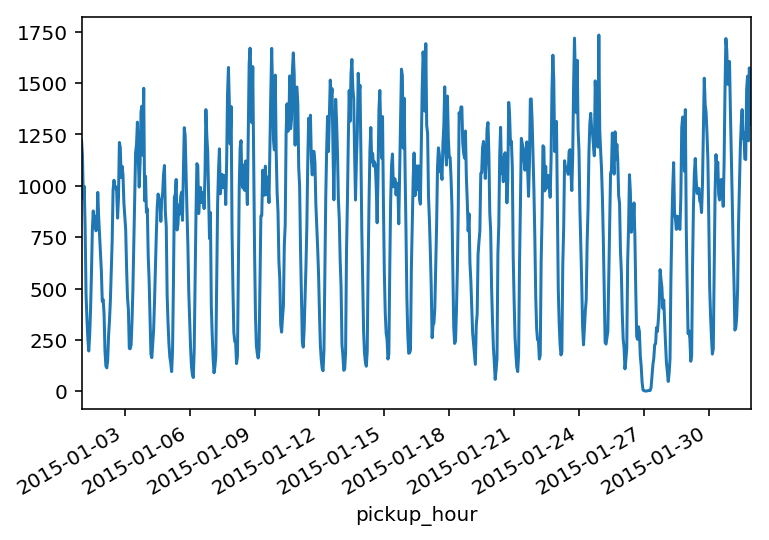

In [20]:
zip_df[zip_df['zip_code'] == '10001'].set_index('pickup_hour')['cnt'].plot();

### 하루 단위 zip_code별 Trip Box Plot

In [21]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]

In [23]:
filter_zip_daily_df = filter_zip_df.groupby(['zip_code','date'])[['cnt']].sum().reset_index()

In [24]:
# cufflinks => 드래그로 가능
filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

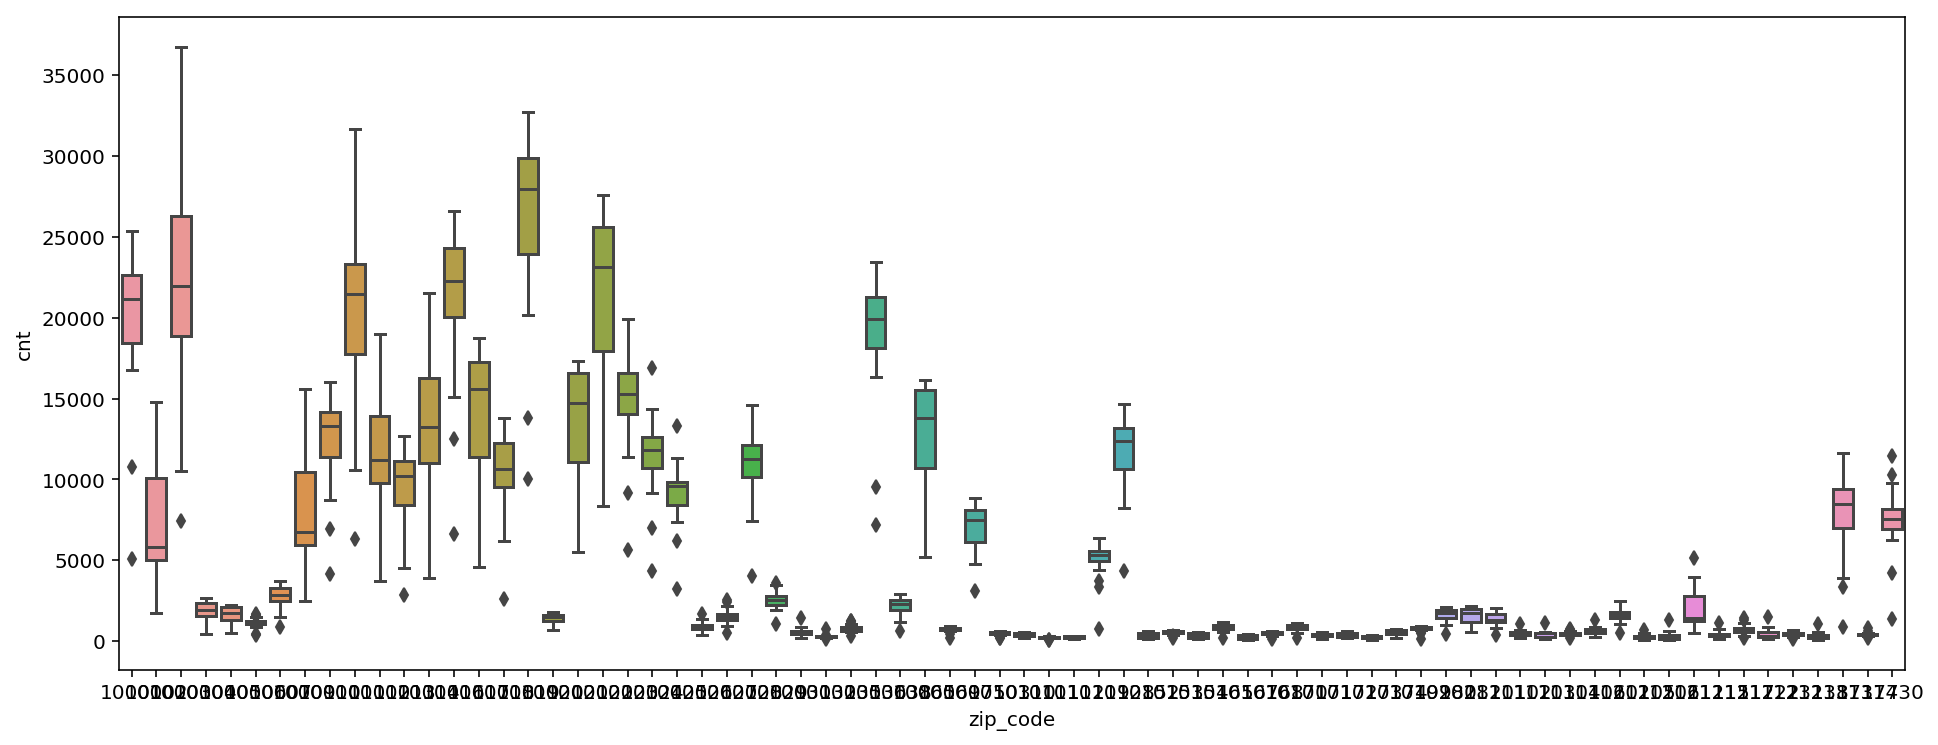

In [27]:
# seaborn
plt.figure(figsize=(16, 6));
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df);

In [28]:
filter_zip_df[filter_zip_df['zip_code'] == '10001']

,zip_code,zip_code_geom,pickup_hour,cnt,date
19,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 00:00:00,1221,2015-01-01
230,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 01:00:00,1151,2015-01-01
374,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 02:00:00,939,2015-01-01
539,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 03:00:00,997,2015-01-01
726,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 04:00:00,794,2015-01-01
884,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 05:00:00,472,2015-01-01
1042,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 06:00:00,353,2015-01-01
1185,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 07:00:00,257,2015-01-01
1344,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 08:00:00,196,2015-01-01
1396,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 09:00:00,270,2015-01-01


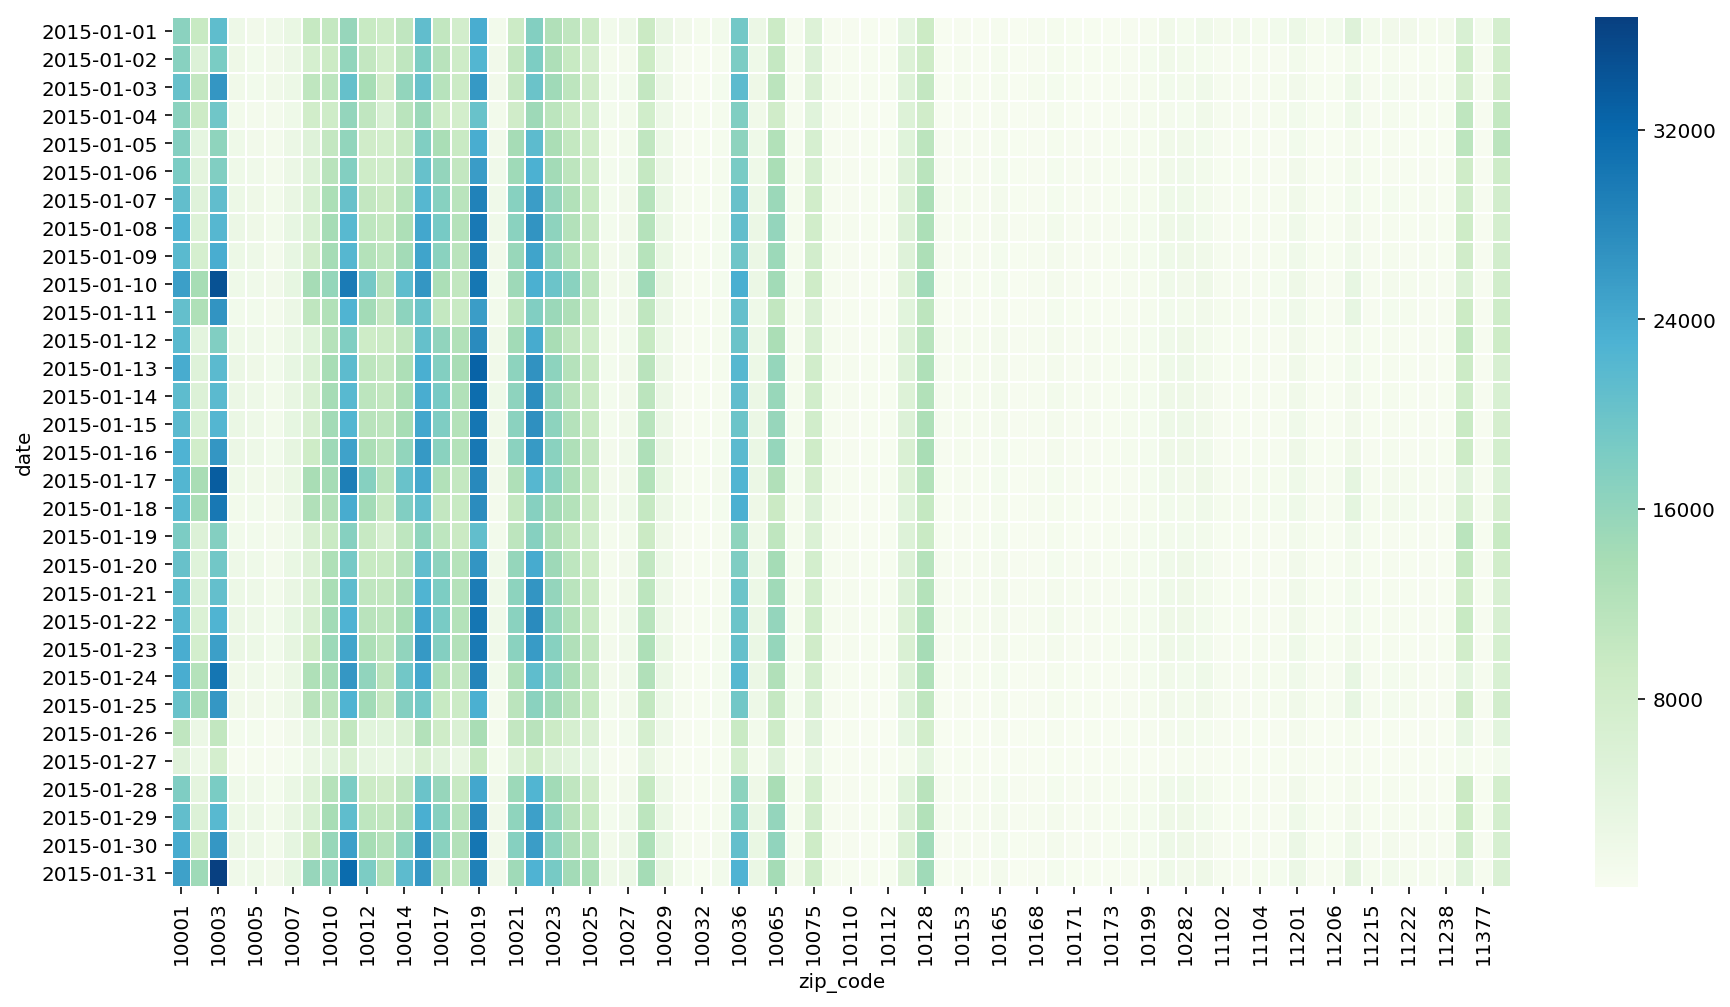

In [29]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),
           lw=.5, cmap='GnBu');

### 시간대별 zip_code의 추이

In [30]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour

In [31]:
filter_zip_df.head(3)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
2,10110,"POLYGON((-73.983624 40.755516, -73.984118 40.7...",2015-01-01,35,2015-01-01,0
3,10036,"POLYGON((-74.001537 40.761487, -74.001622 40.7...",2015-01-01,772,2015-01-01,0
6,10075,"POLYGON((-73.964687 40.775677, -73.965148 40.7...",2015-01-01,444,2015-01-01,0


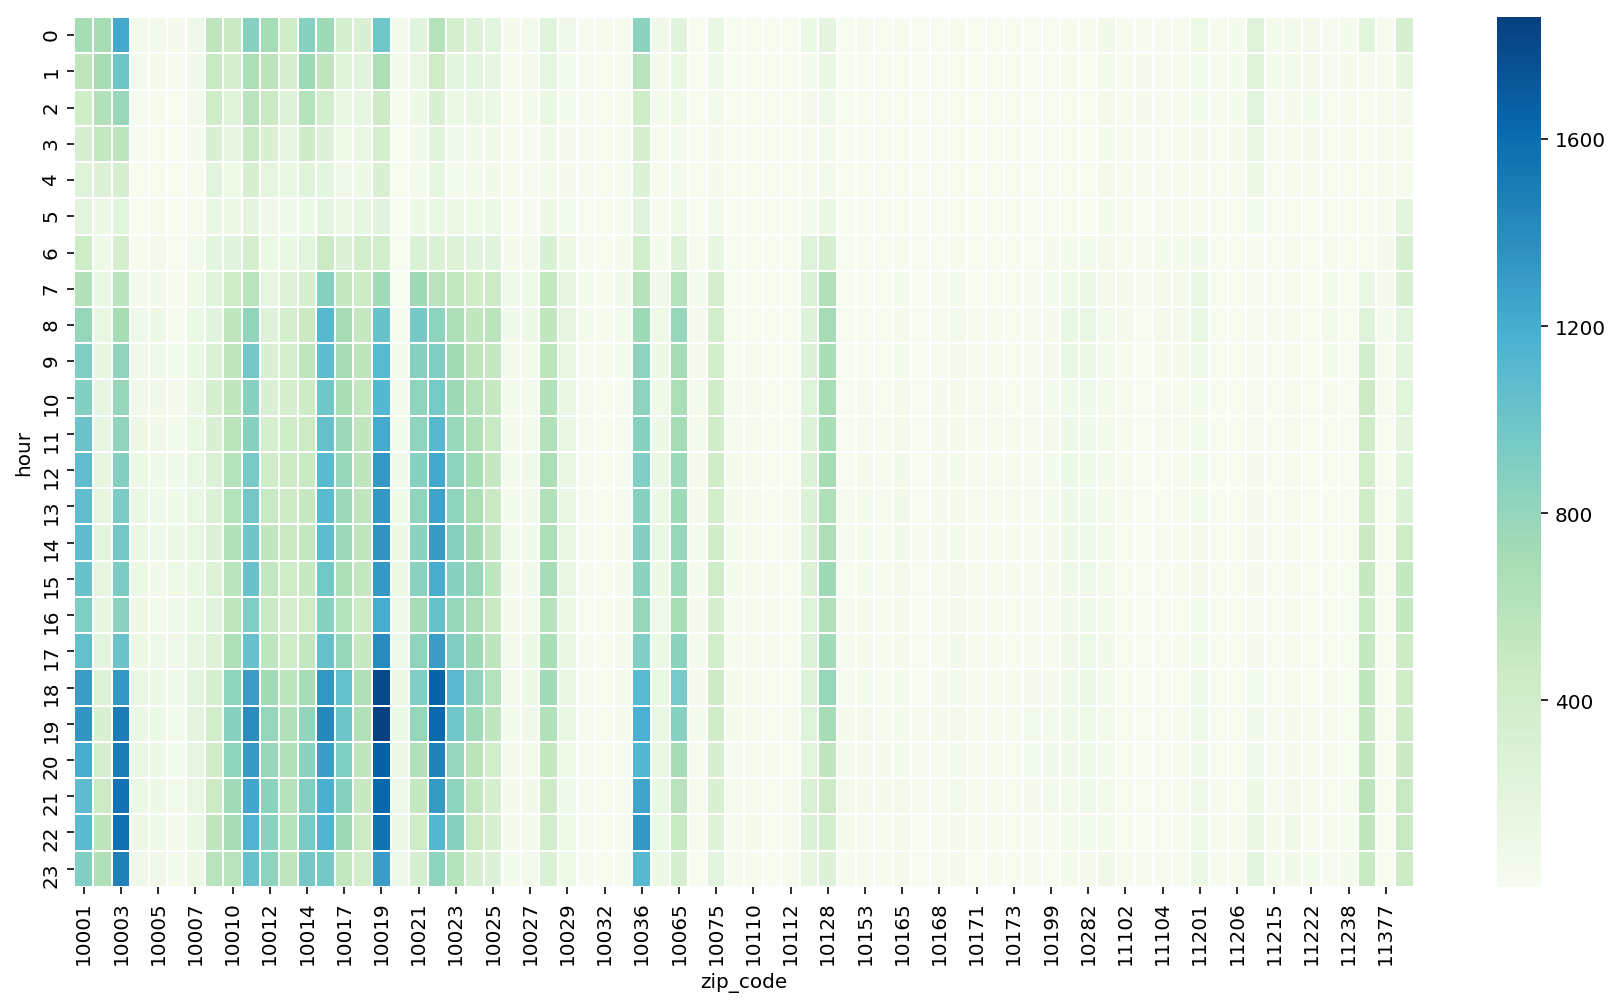

In [32]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.5, cmap='GnBu');